In [1]:
#Imports
import time
import random
import cv2
import os
import math
import dcor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
from PIL import Image
import hashlib
get_ipython().run_line_magic('matplotlib', 'inline')
import scipy


In [2]:
expValue =  4294967296  

n = 20
originalKey =   0x74cbb174cbb174cbb174cbb174cbb174cbb1
scale = 256

mdiffRound = 1

In [3]:
def PL_PWLCM(y0,p2):
    y1=0
    if y0<p2:
        y1 = math.floor(expValue*y0/p2)
    elif p2<y0 and y0 < expValue/2:
        y1 = math.floor(expValue*(y0-p2)/(expValue/2 - p2))
    elif y0 == expValue/2 :
        y1 = 0
    else:
        y1 = PL_PWLCM(expValue-y0, p2)
    return y1

#Coupled Logistic Map
def PL_Logistic(x0):
    x1 = math.floor(4*x0*(expValue-x0)/expValue)
    return x1

def PWLCM_Init(x0,y0,p1,p2):
    x1 = x0
    y1 = y0
    for i in range(n):
        x1 = PL_PWLCM_IMPR(x1,p1)
        y1 = PL_PWLCM_IMPR(y1,p2)
    return x1,y1

def Logistic_Init(x0):
    x1 = x0
    for i in range(n):
        x1 = PL_Logistic(x1)
    return x1

#Improvised Piecewise Linear Chaotic Map
#p2 (0,0.5)
def PL_PWLCM_IMPR(y0,p2):
    #(x-[x/q]*q)/q
    #With precision
    t2 =  math.floor(y0/p2)*p2
    t1 = expValue*(y0-t2)/p2
    return t1




In [4]:
# Initialization
def getParas(key):
    p2 = key & 0x7fffffff
    z0 = (key>>31) & 0x7fffffff
    p1 = (key>>62) & 0x7fffffff
    y0 = (key>>93) & 0x7fffffff
    x0 = (key>>124) & 0xffffffff
    x0,y0,z0 = InitPRNG(x0,y0,p1,z0,p2)    
    return x0,y0,p1,z0,p2


def InitPRNG(x0,y0,p1,z0,p2):
    
    for i in range(n):
        y1,z1 = PWLCM_Init(y0,z0,p1,p2)
        x1 = Logistic_Init(x0)
    return x1,y1,z1

#32 bit r1
def PL_PWLCM_Logistic(x0,y0,p1,z0,p2):
    
    y1 = PL_PWLCM(y0,p1)
    z1 = PL_PWLCM(z0,p2)
    x1 = PL_Logistic(x0)
    temp1 = x1 ^ y1
    r1 = (temp1 + z1) % expValue
    return x1,y1,z1,r1


# get the second column
def takeSecond(elem):
    return elem[1]


In [5]:
def getPixelPermutationMatrix(a,b,c,x0,y0,p1,z0,p2):
     
    #a,b,c are dimensions equivalent to w,h*d,1
    
    #Time needed is (WxH)/4
    #iLen is when we divide the number of pixels by 4. (Number of 4-pixeled units)
    iLen = math.ceil(a*b*c/4)
    
    # if the a and c are not the interal multiple of 2, discard the last row and column  
    sortLength = (a//2)*(b//2)*c 
    
    
    PermutationList = list();
    
    
    for iNum in range(iLen):
        
        x0,y0,z0,res = PL_PWLCM_Logistic(x0,y0,p1,z0,p2)
        
        if iNum < sortLength:
            #Add the Rn generated sortLenght times (Total/4 pixels)
            #This is the Sp matrix
            PermutationList.append([iNum,res])
    
        
    
    #Sort the Permutation in increasing iNum
    PermutationList.sort(key=takeSecond)
    
            
                        
    return PermutationList,x0,y0,z0



def getRowsAndColPermutationMatrix(a,b,c,x0,y0,p1,z0,p2):
    
    #Time is a+b
    #a,b,c are dimensions equivalent to w,h*d,1
    mWidth = a
    mHeight = b
    
    rowList= list()
    colList = list()
    
    
    for x in range(mWidth):
        x0,y0,z0,res = PL_PWLCM_Logistic(x0,y0,p1,z0,p2)
        rowList.append([x,res])
        
    for y in range(mHeight):
        x0,y0,z0,res = PL_PWLCM_Logistic(x0,y0,p1,z0,p2)
        colList.append([y,res])
        

        
    
    #Sort the Permutation in increasing iNum
    rowList.sort(key=takeSecond)
    colList.sort(key=takeSecond)
    
    
    return rowList,colList,x0,y0,z0


In [6]:
def getDiffusionMatrix(a,b,c,x0,y0,p1,z0,p2):
    
    #Time needed is (WxH)/4
    #iLen is when we divide the number of pixels by 4. (Number of 4-pixeled units)
    iLen = int(math.ceil(a*b*c)/4)
    DiffusionList = np.zeros(a*b*c, dtype = np.int, order = 'C')
    
    
    for iNum in range(iLen):
        
        x0,y0,z0,res = PL_PWLCM_Logistic(x0,y0,p1,z0,p2)
        
        #Split Rn into 4 *-bit numbers and put in the Sd (Diffusion matrix) 
        if (iNum+1)*4 <= a*b*c:
            DiffusionList[iNum*4] = (res >> 24) & 0xff
            DiffusionList[iNum*4+1] = (res >> 16) & 0x00ff
            DiffusionList[iNum*4+2] = (res >> 8) & 0x0000ff
            DiffusionList[iNum*4+3] = (res >> 0) & 0x000000ff
       
        #When it is not a multiple of 4, discard whatever is left
        else:
            tail = a*b*c % 4
            shiftUnit = [0xff,0x00ff,0x0000ff,0x000000ff]
            for i in range(tail):
                DiffusionList[iNum*4+i] = (res >> 24-i*8) & shiftUnit[i]
        

        
                        
    if c == 1: #gray
    
        DiffusionList = DiffusionList.reshape(a,b)
    
        return DiffusionList,x0,y0,z0
    else:
    
        DiffusionList = DiffusionList.reshape(a,b,c)
    
        return DiffusionList,x0,y0,z0

In [7]:
#Augmented Permutation model
#Encryption
def doPixelPermutationEncryption(img,permutationKey):
    
    w,h = img.shape
    
    #confusion
    c =  np.zeros((w,h), dtype=np.int)
    c = img.copy()
    istep = h//2
    k = permutationKey
   

    #Iterate over all the permutationSort based keys
    for i in range(len(permutationKey)):
          
            #k[i] = 3436520711
            #iStep = h/2 = 5
            
            iRow = (k[i]//istep)*2
            iCol = (k[i] % istep)*2
            iRow0 = (i // istep)*2
            iCol0 = (i % istep)*2
            
            #4 units of a pixel
            c[iRow0,iCol0] = img[iRow,iCol]
            c[iRow0+1,iCol0] = img[iRow+1,iCol]
            c[iRow0,iCol0+1] = img[iRow,iCol+1]
            c[iRow0+1,iCol0+1] = img[iRow+1,iCol+1]

    
    cv2.imwrite('1enc_pixel_permutation.jpg',c)
    return c


def doRowColPermutationEncryption(img, rowList, colList):
    
    
    w,h = img.shape
    c =  np.zeros((w,h), dtype=np.int)
    c = img.copy()
    istep = h//2
   

    #For the permutation of the rows
    for i in range(len(rowList)):
            #All cols of c and its row i is equal to all cols of img and the rowLits[i] row of img 
            c[i,:] = img[rowList[i],:]
 
    
    c1 =  np.zeros((w,h), dtype=np.int)
    c1= c.copy()
    
    for j in range(len(colList)):
            #All rows of c and its col j is equal to all rows of img and the colList[i] row of img 
            c1[:,j] = c[:,colList[j]]
     
  
    
    cv2.imwrite('2enc_row_col_permutation.jpg',c1)
    return c1

def doPermutationEncryption(img, permutationList, rowList, colList):
    
    
    arr = np.array(permutationList)
    arr1= np.array(rowList)
    arr2 =np.array(colList)
        
    #For pixel unit level
    sortkey = arr[:,0]
    
    #For row and col unit level
    sortkeyRow = arr1[:,0]
    sortkeyCol = arr2[:,0]
    
    
    #Do row/col permutation
    img = doRowColPermutationEncryption(img,sortkeyRow, sortkeyCol)
  
  
    #Do pixel permutation
    img = doPixelPermutationEncryption(img,sortkey)
    
  
    
    cv2.imwrite('3enc_full_permutation.jpg',img)
    return img


#Decryption

def doPixelPermutationDecryption(c,permutationKey):
    
    
    w,h = c.shape
    
    #confusion
    b =  np.zeros((w,h), dtype=np.int)
    b = c.copy()
    istep = h//2
    
    k = permutationKey

    #k (Sort key is the index in sorted order)
    for i in range(len(permutationKey)):
          
            iRow = (k[i]//istep)*2
            iCol = (k[i] % istep)*2
            iRow0 = (i // istep)*2
            iCol0 = (i % istep)*2
            b[iRow,iCol] = c[iRow0,iCol0]
            b[iRow+1,iCol] = c[iRow0+1,iCol0]
            b[iRow,iCol+1] = c[iRow0,iCol0+1]
            b[iRow+1,iCol+1] = c[iRow0+1,iCol0+1]
    


    
    cv2.imwrite('12dec_pixel_permutation.jpg',b)
    return b


def doRowColPermutationDecryption(img, rowList, colList):
    
    w,h = img.shape
    c =  np.zeros((w,h), dtype=np.int)
    c = img.copy()
    istep = h//2
   
    for j in range(len(colList)):
            #All rows of c and its col j is equal to all rows of img and the colList[i] row of img 
            c[:,colList[j]] = img[:,j]
  
    c1 =  np.zeros((w,h), dtype=np.int)
    c1 = c.copy()
    
    #For the permutation of the rows
    for i in range(len(rowList)):
            #All cols of c and its row i is equal to all cols of img and the rowLits[i] row of img 
            c1[rowList[i],:] = c[i,:]
 
  
            
    
    cv2.imwrite('11dec_row_col_permutation.jpg',c1)
    return c1

def doPermutationDecryption(img, permutationList, rowList, colList):
    
    
    arr = np.array(permutationList)
    arr1= np.array(rowList)
    arr2 =np.array(colList)
        
    #For pixel unit level
    sortkey = arr[:,0]
    
    #For row and col unit level
    sortkeyRow = arr1[:,0]
    sortkeyCol = arr2[:,0]
    
    
    #Do row/col permutation
    img = doRowColPermutationDecryption(img,sortkeyRow, sortkeyCol)
  
    #Do pixel permutation
    img = doPixelPermutationDecryption(img,sortkey)
    
  
    
    cv2.imwrite('13dec__permutation.jpg',img)
    return img

    

In [8]:
#Augmented Diffusion Model
#Input is the permuted image
windowSize = 64
strideSize = 16

def getPartsAcrossLength(b):
    
    #For the image spanning over b units, finding the number of parts of size 64 and stride 16
    #Over the span of 2*windowSize-strideSize, we have 2 windows and 1 stride of size
    parts = int((b-windowSize)/ (windowSize-strideSize)) + 1;        
    remaining = b-(parts-1)*(windowSize-strideSize) - windowSize
    
    #Eg, b=768, w = 64, s = 16, w-s = 48 numParts = 1+(768-64)48 = 15
    #Reamining = 768-(14)*48-64
    return parts, remaining
    
#Encryption
def rowDiffusionByPartEncryption(img,ValueKey):
    
    
    w,h = img.shape
    b = np.zeros((w,h), dtype=np.int)
    b = img.copy()
    

    mPart = 1
    miter = 0
    
    numParts, remaining = getPartsAcrossLength(w)
    
    
    
    for iwhole in range(mdiffRound):
    
            for iRow in range(0,w,1):
#             for iRow in range(0,w-remaining,1):
               
#                 if mPart == 1 and iRow == windowSize:
                    
#                     mPart = mPart + 1
#                     miter = iRow-strideSize 
                    
#                     for inRow in range(strideSize):

#                         if miter == 0:
#                             b[miter,:] = (b[-1,:] + b[miter,:] + ValueKey[miter,:]) % scale
#                         else:
#                             b[miter,:] = (b[miter-1,:] + b[miter,:] + ValueKey[miter,:]) % scale
                        
#                         miter= miter+1

#                 elif mPart != 1 and iRow-(mPart-1)*(windowSize-strideSize) == windowSize:
#                     mPart = mPart + 1
#                     miter = iRow-strideSize 
                    
#                     for inRow in range(strideSize):

#                         if miter == 0:
#                             b[miter,:] = (b[-1,:] + b[miter,:] + ValueKey[miter,:]) % scale
#                         else:
#                             b[miter,:] = (b[miter-1,:] + b[miter,:] + ValueKey[miter,:]) % scale
                        
#                         miter= miter+1

                    

#Original                  
                if miter == 0:
                    b[miter,:] = ( b[miter,:] +b[-1,:] +ValueKey[miter,:]) % scale

                else:
                    b[miter,:] = (b[miter-1,:] + b[miter,:] + ValueKey[miter,:]) % scale

                miter= miter+1

#             for rem in range(w,w-remaining,-1):
#                 if miter == 0:
#                     b[miter,:] = ( b[miter,:] +b[-1,:] +ValueKey[miter,:]) % scale

#                 else:
#                     b[miter,:] = (b[miter-1,:] + b[miter,:] + ValueKey[miter,:]) % scale

#                 miter= miter+1

            mPart = 1
            miter = 0
   

        
    
    cv2.imwrite('4enc_row_diffusion.jpg',b)
  
    return b


def colDiffusionByPartEncryption(img,ValueKey):
    
    
    #For each part
    w,h1 = img.shape
    b = np.zeros((w,h1), dtype=np.int)
    b = img.copy()
    
    h=h1-1
    mPart = 1
    miter = 0
    
    numParts, remaining = getPartsAcrossLength(h1)
   
   

    #Requires 2 rounds of diffusion
    for iwhole in range(mdiffRound):
    
            for iRow in range(0,h,1):
#             for iRow in range(0,h-remaining+1,1):
               
                
#                 if mPart == 1 and iRow == windowSize:
#                     mPart = mPart + 1
#                     miter = iRow-strideSize 
                    
#                     for inRow in range(0,strideSize,1):

#                         #If it is the first row
#                         if miter == 0:
#                             #Take the current row, the last row, and correspoding row from the diffsion matrix and then scale
#                             b[:,miter] = (b[:,-1] + b[:,miter] + ValueKey[:,miter]) % scale
#                         else:
#                             #Else, take the current and the previous row with the diffusion matrix row
#                             b[:,miter] = (b[:,miter-1] + b[:,miter] + ValueKey[:,miter]) % scale
#                         miter= miter+1
                                    
                            
#                 elif mPart != 1 and iRow-(mPart-1)*(windowSize-strideSize) == windowSize:
                    
#                     miter = iRow-strideSize
#                     mPart = mPart + 1
                     
#                     for inRow in range(0,strideSize,1):
                        
                    
#                         if miter == 0:
#                             b[:,miter] = (b[:,-1] + b[:,miter] + ValueKey[:,miter]) % scale
#                         else:
#                             b[:,miter] = (b[:,miter-1] + b[:,miter] + ValueKey[:,miter]) % scale
                        
#                         miter= miter+1
               
                
                #If it is the first row
#Original
                if miter == 0:
                    b[:,miter] = (b[:,-1] + b[:,miter] + ValueKey[:,miter]) % scale
                else:
                    b[:,miter] = (b[:,miter-1] + b[:,miter] + ValueKey[:,miter]) % scale
                
                miter= miter+1
                
            
#             for rem in range(h,h-remaining,-1):
                
#                 if miter == 0:
#                     b[:,miter] = (b[:,-1] + b[:,miter] + ValueKey[:,miter]) % scale
#                 else:
#                     b[:,miter] = (b[:,miter-1] + b[:,miter] + ValueKey[:,miter]) % scale
                
#                 miter= miter+1

            mPart = 1
            miter = 0
   
        

    cv2.imwrite('5enc_col_diffusion.jpg',b)
    return b


    
    
    
     
def augmentedDiffusionEncryption(img,a,b,c, ValueKey):
    
    
  
    img = rowDiffusionByPartEncryption(img, ValueKey)
    img = colDiffusionByPartEncryption(img,ValueKey)
    
    cv2.imwrite('6enc_whole_diffusion.jpg',img)
  
    return img
    

def rowDiffusionByPartDecryption(img,ValueKey):
    
    #For each part
    w1,h = img.shape
    b = np.zeros((w1,h), dtype=np.int)
    b = img.copy()
    
    w=w1-1
    mPart = 1
    miter = w
   

    numParts, remaining = getPartsAcrossLength(w1)
    holdingNumber = 1
    
    for iwhole in range(mdiffRound):
    
#             for rem in range(w,w-remaining,-1):
#                 if miter == 0:
#                         b[miter,:] = (-b[-1,:] + b[miter,:] - ValueKey[miter,:]) % scale
#                 else:
#                     b[miter,:] = (-b[miter-1,:] + b[miter,:] - ValueKey[miter,:]) % scale
                
#                 miter= miter-1
            
            
            
            for iRow in range(w-1,-1,-1):
            #for iRow in range(0,w-remaining+1,1):
   
                
#                 if mPart == 1 and iRow == windowSize:
#                     mPart = mPart + 1
#                     miter = (w-remaining-iRow)+strideSize 
#                     holdingNumber = iRow
                    
#                     for inRow in range(0,strideSize,1):
                        
#                         if miter == 0:
#                             b[miter,:] = (-b[-1,:] + b[miter,:] - ValueKey[miter,:]) % scale
#                         else:
#                             b[miter,:] = (-b[miter-1,:] + b[miter,:] - ValueKey[miter,:]) % scale
                        
#                         miter= miter-1
                
#                 elif mPart != 1 and iRow-(mPart-1)*(windowSize-strideSize) == holdingNumber:
#                     mPart = mPart + 1
#                     miter = (w-remaining-iRow)+strideSize 
                    
#                     for inRow in range(0,strideSize,1):
                        
#                         if miter == 0:
#                             b[miter,:] = (-b[-1,:] + b[miter,:] - ValueKey[miter,:]) % scale
#                         else:
#                             b[miter,:] = (-b[miter-1,:] + b[miter,:] - ValueKey[miter,:]) % scale
                        
#                         miter= miter-1
                
                    
                
                
                
                if miter == 0:
                    b[miter,:] = (-b[-1,:] + b[miter,:] - ValueKey[miter,:]) % scale
                else:
                    b[miter,:] = (-b[miter-1,:] + b[miter,:] - ValueKey[miter,:]) % scale

                miter= miter-1

                
            
            mPart = 1
            miter = 0
   
            
            
    cv2.imwrite('9dec_row_diffusion.jpg',b)
    return b


def colDiffusionByPartDecryption(img, ValueKey):
    
    #For each part
    w,h1 = img.shape
    b = np.zeros((w,h1), dtype=np.int)
    b = img.copy()
    
    h = h1-1
    mPart = 1
    miter = h
    
    holdingNumber = 1
    
    numParts, remaining = getPartsAcrossLength(h1)
   
    for iwhole in range(mdiffRound):
            
#             for rem in range(h,h-remaining,-1):
                
                
#                 if miter == 0:
#                     b[:,miter] = (-b[:,-1] + b[:,miter] - ValueKey[:,miter]) % scale
#                 else:
#                     b[:,miter] = (-b[:,miter-1] + b[:,miter] - ValueKey[:,miter]) % scale
                
            
#                 miter= miter-1

            
#             for iRow in range(0,h-remaining+1,1):
            for iRow in range(h-1,-1,-1):
        
              
#                 if mPart == 1 and  iRow == windowSize:
                   
#                     holdingNumber = iRow
#                     mPart = mPart + 1
#                     miter = (h-remaining-iRow)+strideSize 
                    
#                     for inRow in range(0,strideSize,1):

#                         if miter == 0:
#                             b[:,miter] = (-b[:,-1] + b[:,miter] - ValueKey[:,miter]) % scale
#                         else:
#                             b[:,miter] = (-b[:,miter-1] + b[:,miter] - ValueKey[:,miter]) % scale
                        
#                         miter= miter-1
                
#                 elif mPart != 1 and iRow-(mPart-1)*(windowSize-strideSize) == holdingNumber:
#                     mPart = mPart + 1
#                     miter = (h-remaining-iRow)+strideSize 
                    
#                     for inRow in range(0,strideSize,1):

#                         if miter == 0:
#                             b[:,miter] = (-b[:,-1] + b[:,miter] - ValueKey[:,miter]) % scale
#                         else:
#                             b[:,miter] = (-b[:,miter-1] + b[:,miter] - ValueKey[:,miter]) % scale
                        
#                         miter= miter-1
                
                
                
                if miter == 0:
                    b[:,miter] = (-b[:,-1] + b[:,miter] - ValueKey[:,miter]) % scale
               
                else:
                    b[:,miter] = (-b[:,miter-1] + b[:,miter] - ValueKey[:,miter]) % scale
                
                 
                miter= miter-1
        
            mPart = 1
            miter = 0
   
                
    
#     print('In end, parts are mPart = ', mPart)
    cv2.imwrite('8dec_col_diffusion.jpg',b)
  
    return b


     
def augmentedDiffusionDecryption(img,a,b,c, ValueKey):
    
    
    img = colDiffusionByPartDecryption(img, ValueKey)

    img = rowDiffusionByPartDecryption(img, ValueKey)
    
    
    cv2.imwrite('10dec_whole_diffusion.jpg',img)
  
    return img    
    

In [9]:
def ENCRYPTION(img, permutationList,rowList,colList, ValueKey, a,b,c):
    
    
    #Call permutation
    img = doPermutationEncryption(img,permutationList,rowList, colList)
    #Call diffusion
    img = augmentedDiffusionEncryption(img,a,b,c,ValueKey)
    
    
    
    return img

def doEnc(img,k):
    
    time_start=time.time()
    iterRound = 1 # Encryption round
    w,h,d = img.shape #return row and column
    img = img.reshape((w,h*d))
    
    for i in range(iterRound):
        
        x0,y0,p1,z0,p2 = getParas(k)  
        sortkey,x0,y0,z0 = getPixelPermutationMatrix(w,h*d,1,x0,y0,p1,z0,p2)
        rowList,colList,x0,y0,z0=getRowsAndColPermutationMatrix(w,h*d,1,x0,y0,p1,z0,p2)
        ValueKey,x0,y0,z0 = getDiffusionMatrix(w,h*d,1,x0,y0,p1,z0,p2)
       
        
        img = ENCRYPTION(img,sortkey,rowList,colList,ValueKey,w,h*d,1)
        
    img = img.reshape((w,h,d))
    time_end=time.time()
    print('Enc time cost:',time_end-time_start,'s')
   

    cv2.imwrite('7enc_whole_result.jpg',img)
  
    return img
    
def DECRYPTION(img, permutationList,rowList,colList, ValueKey, a,b,c):
    
    
    
    #Call diffusion
    img = augmentedDiffusionDecryption(img,a,b,c,ValueKey)
    #Call permutation
    img = doPermutationDecryption(img,permutationList,rowList, colList)
 
    return img

def doDec(img,k):
    
    time_start=time.time()
    iterRound = 1 # Encryption round
    w,h,d = img.shape #return row and column
    img = img.reshape((w,h*d))
    
    for i in range(iterRound):
        
        x0,y0,p1,z0,p2 = getParas(k)
        sortkey,x0,y0,z0 = getPixelPermutationMatrix(w,h*d,1,x0,y0,p1,z0,p2)
        rowList,colList,x0,y0,z0=getRowsAndColPermutationMatrix(w,h*d,1,x0,y0,p1,z0,p2)
        ValueKey,x0,y0,z0 = getDiffusionMatrix(w,h*d,1,x0,y0,p1,z0,p2)
        
        
        img = DECRYPTION(img,sortkey,rowList,colList,ValueKey,w,h*d,1)
        
    
    img = img.reshape((w,h,d))
    time_end=time.time()
    print('Dec time cost:',time_end-time_start,'s')
    
    cv2.imwrite('14dec_whole_result.jpg',img)
    return img
    

    

In [10]:
#Histograms Analysis
def expectation(x,f):
    tatal = 0.0
    for i in range(f):
        tatal = tatal + x[i]
    E = tatal/n
    return E

def Variance(x,f):
    varValue = 0.0
    expValue = expectation(x,f)
    for i in range(f):
        varValue = varValue + math.pow(x[i]-expValue,2)
    return varValue/f

def getVariances(listIm):
    
    for imp in listIm:
        arr= imgP.flatten()
        varValue = Variance(arr,arr.size)
        print("Variance is ",str(varValue))
        
def histogram(listOfIm):
    icount = 0
    index = len(listOfIm)
    
    plt.figure(figsize=(26,9*index),dpi=100)
    plt.rcParams['axes.titlesize'] = 25
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    # key = [0x7833A013F4DB0018F4FB4031E9F680BC614A,0x7833A013F4DB0018F4FB4031E9F680BC614B]
    key = [originalKey]
    
    for imgP in listOfIm:
        
        arr= imgP.flatten()
        varValue = Variance(arr,arr.size)
        plt.subplot(index,2,2+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='gray', alpha=0.75)
        plt.title("Encrypted ")
        plt.xlabel('Gray Value')
        plt.ylabel('Distribution')
        print("Variance is ",str(varValue))
        icount += 1




In [11]:
#Test for diffusion
#PASS
def testDiffusion(img, k):
    
    w,h,d = img.shape #return row and column
    img =img.reshape((w,h*d))
    x0,y0,p1,z0,p2 = getParas(k)
    
    
    sortkey,x0,y0,z0 = getPixelPermutationMatrix(w,h*d,1,x0,y0,p1,z0,p2)
    rowList,colList,x0,y0,z0=getRowsAndColPermutationMatrix(w,h*d,1,x0,y0,p1,z0,p2)
    ValueKey,x0,y0,z0 = getDiffusionMatrix(w,h*d,1,x0,y0,p1,z0,p2)
    
    #Test col diffusion
    imgE = augmentedDiffusionEncryption(img,w,h*d,1,ValueKey)
    
    cv2.imwrite('diffusedImage.jpg',imgE)
    imgD = augmentedDiffusionDecryption(imgE,w,h*d,1,ValueKey)
   
    imgD = imgD.reshape((w,h,d))
    cv2.imwrite('unDiffusedImage.jpg',imgD)
    
    #PASS
    return imgE,imgD


def testPermutation(img, k):
    w,h,d = img.shape #return row and column
    img =img.reshape((w,h*d))
    x0,y0,p1,z0,p2 = getParas(k)
    
    
    permutationList,x0,y0,z0 = getPixelPermutationMatrix(w,h*d,1,x0,y0,p1,z0,p2)
    rowList,colList,x0,y0,z0=getRowsAndColPermutationMatrix(w,h*d,1,x0,y0,p1,z0,p2)
    ValueKey,x0,y0,z0 = getDiffusionMatrix(w,h*d,1,x0,y0,p1,z0,p2)
    
    imgE = doPermutationEncryption(img,permutationList,rowList,colList)
    
    cv2.imwrite('diffusedImage.jpg',imgE)
    imgD = doPermutationDecryption(imgE,permutationList,rowList,colList)
   
    imgD = imgD.reshape((w,h,d))
    cv2.imwrite('unDiffusedImage.jpg',imgD)
    
    #PIXEL IS PASS
    #ROW COL IS PASS
    return imgE,imgD

    
def testWhole(img, k):
    
    w,h,d = img.shape #return row and column
    img =img.reshape((w,h*d))
    x0,y0,p1,z0,p2 = getParas(k)
    
    
    permutationList,x0,y0,z0 = getPixelPermutationMatrix(w,h*d,1,x0,y0,p1,z0,p2)
    rowList,colList,x0,y0,z0=getRowsAndColPermutationMatrix(w,h*d,1,x0,y0,p1,z0,p2)
    ValueKey,x0,y0,z0 = getDiffusionMatrix(w,h*d,1,x0,y0,p1,z0,p2)
    
    imgE = ENCRYPTION(img,permutationList,rowList,colList, ValueKey, w,h*d,1)
    
    imgD = DECRYPTION(imgE,permutationList,rowList,colList, ValueKey, w,h*d,1)
   
    imgD = imgD.reshape((w,h,d))
    imgE = imgE.reshape((w,h,d))
    
    cv2.imwrite('unDiffusedImage.jpg',imgD)
    
    cv2.imwrite('diffusedImage.jpg',imgE)
    
    #PIXEL IS PASS
    #ROW COL IS PASS
    return imgE,imgD

    
    
    
 
    

In [12]:
#Correlation Analysis
from PIL import Image
from matplotlib.widgets import Cursor
import numpy as np
import matplotlib.pyplot as plt
import math

def expectation(x,nf):
    #print(x)
    tatal = 0.0
    for i in range(nf):
        tatal = tatal + x[i]
    E = tatal/nf
    #print(E)
    return E

def Variance(x,nf):
    varValue = 0.0
    eValue = expectation(x,nf)
    for i in range(nf):
        varValue = varValue + math.pow(x[i]-eValue,2)
    return varValue/nf

def cov(x,y,n):
    covValue = 0.0
    expX = expectation(x,n)
    expY = expectation(y,n)
    for i in range(n):
        covValue = covValue + (x[i] - expX)*(y[i]-expY)
    return covValue/n
def corr_coefficient(x,y,n):
    covValue = cov(x,y,n)
    varX = Variance(x,n)
    varY = Variance(y,n)
    varX = math.sqrt( varX )
    varY = math.sqrt( varY )
    #print(covValue,varX,varY)
    return  covValue/(varX*varX)

def Correlation(img,img2,LineColor,itype):
    x0=[]
    x1=[]
    y0=[]
    y1=[]
    
    if itype == 'Horizontal':
        for a in range(128):
            for b in range(32):
                x0.append(img2[2*a][4*b])
                x1.append(img2[1+2*a][4*b])
                y0.append(img[2*a][4*b])
                y1.append(img[1+2*a][4*b])
    elif itype == 'Vertical':
        for a in range(32):
            for b in range(128):
                x0.append(img2[4*a][2*b])
                x1.append(img2[4*a][1+2*b])
                y0.append(img[4*a][2*b])
                y1.append(img[4*a][1+2*b])
    else:
        for a in range(128):
            for b in range(32):
                x0.append(img2[2*a][4*b])
                x1.append(img2[1+2*a][1+4*b])
                y0.append(img[2*a][4*b])
                y1.append(img[1+2*a][1+4*b])
    return x0,x1,y0,y1

def correlation(plain,cipher, typeOfReln):
    r=plain
    r1=cipher
    x0,x1,y0,y1 = Correlation(r,r1,'blue',typeOfReln)
    fig = plt.figure(figsize=(34,10),dpi=100)
    ax = fig.add_subplot(1,2,1, facecolor='#EBEBEB')
    ax.plot(y0, y1, '.',color='gray')
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
    plt.title('Horizontal')
    plt.xlabel("x(m,n)")
    plt.ylabel("x(m,n+1)")
    # Set useblit=True on most backends for enhanced performance.
    cursor = Cursor(ax, useblit=True, color='red', linewidth=2)
    ax = fig.add_subplot(1,2,2, facecolor='#EBEBEB')
    ax.plot(x0, x1, '.',color='gray')
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
    plt.title('Encrypted-'+typeOfReln)
    plt.xlabel("x(m,n)")
    plt.ylabel("x(m,n+1)")
    # Set useblit=True on most backends for enhanced performance.
    cursor = Cursor(ax, useblit=True, color='gray', linewidth=2)
    return 0


In [13]:
import random

def entropy1936(img):
    tmp = np.zeros(256)
    val = 0
    k = 0
    res = 0
    icount = 0
    for i in range(len(img)):
        for j in range(len(img[i])):
            val = img[i][j]
            tmp[val] = float(tmp[val] + 1)
            k =  float(k + 1)
            icount = icount + 1
            if icount > 1936:
                break
        if icount > 1936:
            break
    #print("break point :", icount)
    for i in range(len(tmp)):
        tmp[i] = float(tmp[i] / k)
    for i in range(len(tmp)):
        if(tmp[i] == 0):
            res = res
        else:
            res = float(res - tmp[i] * (math.log(tmp[i]) / math.log(2.0)))
    return res

def get30Blocks(img):
    # k = 30 -> 5 X 6 = 30 and m = 1936 - > block size = 44*44
    a,b = img.shape
    widthLeft = a - 5*44
    if widthLeft < 2:
        widthBegin = 0
    else:
        widthBegin = random.randint(0, widthLeft-1)
    #print("width begin:", widthBegin)
    hightLeft = b - 6*44
    if hightLeft < 2:
        hightBegin = 0
    else:
        hightBegin = random.randint(0, hightLeft-1)
    #print("hight begin:", hightBegin)
    imgBlock = list()
    for i in range(5):
        m = widthBegin + 44*i
        for j in range(6):
            n= hightBegin + 44*j
            temp = img[m:m+44, n:n+44]
            #print("temp image block's shape:", temp.shape)
            imgBlock.append(temp)
    return imgBlock
             
def averagenum(num):
    nsum = 0
    for i in range(len(num)):
        nsum += num[i]
    return nsum / len(num)    
    
def LocalEntropy(cipher):
    
    #step1 select 30 disjoint image blocks
    print("cipher shape:", cipher.shape)
    a,b = cipher.shape


    cipherBlock = list()
    cipherBlock = get30Blocks(cipher)
    localEntropy = list()
    for i in range(len(cipherBlock)):
        temp = entropy1936(cipherBlock[i])
        #print("local entropy: ", temp)
        localEntropy.append(temp)
    
    return averagenum(localEntropy)

def shannonEntropy(img):
    
    marg = np.histogramdd(np.ravel(img), bins = 256)[0]/img.size
    marg = list(filter(lambda p: p > 0, np.ravel(marg)))
    entropy = -np.sum(np.multiply(marg, np.log2(marg)))
    return entropy
    
def distanceCorrelation(u,v):
    
#     d = dcor.distance_correlation(a,b)
#     print('Distance Correlation = ', d)
   
    d = scipy.spatial.distance.correlation(u, v, w=None, centered=True)
    return d



Variance is  2951.6775443117003
Variance is  5482.853022612254
Variance is  2970.4370028070443
Time= 4.089238405227661
Linear Relation between original and encrypted image 0.006932246275168131
Distance Correlation between original and encrypted 0.9957629772565297
Entropy of the original image = 7.426956737962509  and or enc image =  7.999108269291421
Percentage change in entropy =  7.703714341089239


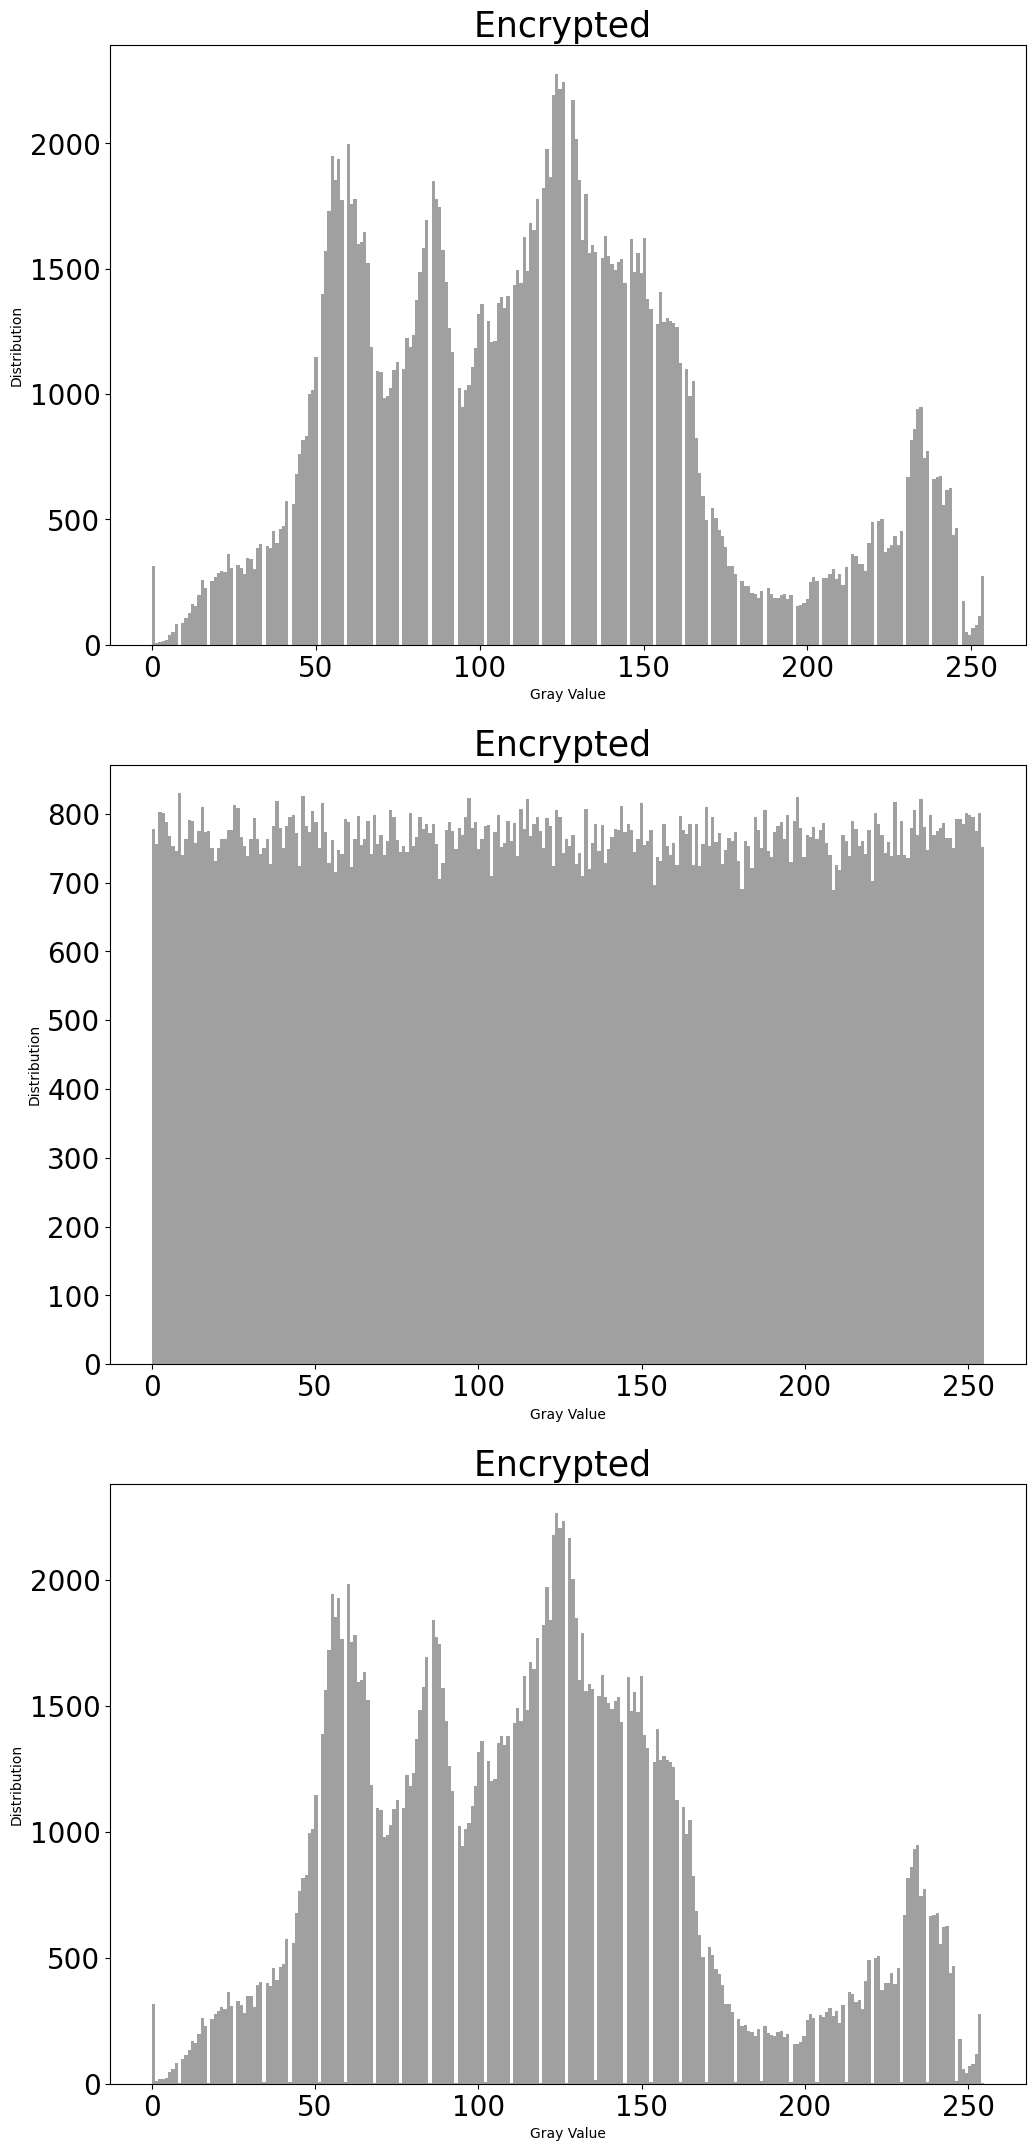

In [14]:
img = cv2.imread('elaine.jpg')

w,h,d = img.shape
# img = img.reshape((w,h*d))
orEn = shannonEntropy(img)
# img = img.reshape((w,h,d))


# encImg = doEnc(img, originalKey)
# cv2.imwrite('encImg.jpg',encImg)

# decImg = doDec(img, originalKey)
# cv2.imwrite('decImg.jpg',decImg)


t1 = time.time()
i1,i2=testWhole(img,originalKey)
t2 = time.time()

listIm = [img,i1,i2]
histogram(listIm)



print('Time=',t2-t1)

print('Linear Relation between original and encrypted image',corr_coefficient(img.flatten(),i1.flatten(),w*h))
print('Distance Correlation between original and encrypted',distanceCorrelation(img.flatten(),i1.flatten()))

# print('\nHorizontal spread for original and encrypted ', correlation(img,i1,'Horizontal'))
# print('\nVertical spread for original and encrypted ', correlation(img,i1,'Vertical'))
# print('\nDiagonal spread for original and encrypted ', correlation(img,i1,'Diagonal'))

# i1 = i1.reshape((w,h*d))
enEn = shannonEntropy(i1)

print('Entropy of the original image =',orEn, ' and or enc image = ', enEn)
print('Percentage change in entropy = ', (((enEn-orEn)/orEn) *100))

#Hybrid(pixel, row) =OPTIMAL
# Entropy of the original image = 7.426956737962509  and or enc image =  7.999061646740582
# Percentage change in entropy =  7.703086593379329
# Linear Relation between original and encrypted image 0.000989925796320189
# Distance Correlation between original and encrypted 0.9988728269431955
#For two rounds (R=1 better)
# Linear Relation between original and encrypted image -0.002233282785294951
# Distance Correlation between original and encrypted 0.9991809061763759
# Entropy of the original image = 7.426956737962509  and or enc image =  7.9988936445330765
# Percentage change in entropy =  7.700824533515065

#Hybrid (Row, Pixel)
# Linear Relation between original and encrypted image 0.007174535316775599
# Distance Correlation between original and encrypted 0.9977254649316344
# Entropy of the original image = 7.426956737962509  and or enc image =  7.999058585418174
# Percentage change in entropy =  7.703045374310522
#For two rounds
# Linear Relation between original and encrypted image -0.0023578276675478094
# Distance Correlation between original and encrypted 0.9998098224719012
# Entropy of the original image = 7.426956737962509  and or enc image =  7.999181369109177
# Percentage change in entropy =  7.7046985910362284



#RowCol
# Entropy of the original image = 7.426956737962509  and or enc image =  7.999065877184291
# Percentage change in entropy =  7.703143554041122
# Linear Relation between original and encrypted image 0.004301747085190222
# Distance Correlation between original and encrypted 0.9941313369763147

#Pixel
# Linear Relation between original and encrypted image 0.008392469838747203
# Distance Correlation between original and encrypted 0.9988360328489421
# Entropy of the original image = 7.426956737962509  and or enc image =  7.999006629999693
# Percentage change in entropy =  7.7023458223902095


#Diffusion Hybrid

